## FEDn API Example

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results

In [1]:
from fedn import APIClient
from fedn.dashboard.plots import Plot
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [2]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Here we initialize FEDn with a compute package and seed model from the mnist-pytorch example. Note that these files needs to be created separately by follwing instructions in the README of that example.

In [4]:
client.set_package('../mnist-pytorch/package.tgz', 'pytorchhelper')
client.set_initial_model('../mnist-pytorch/seed.npz')
seed_model = client.get_initial_model()

Next we start a training session:

In [11]:
session_config_fedavg = {
                    "helper": "pytorchhelper",
                    "session_id": "experiment_fedavg2",
                    "aggregator": "fedavg",
                    "model_id": seed_model['model_id']
                 }

result_fedavg = client.start_session(**session_config_fedavg)

In [6]:
session_config_fedopt = {
                    "helper": "pytorchhelper",
                    "session_id": "experiment_fedopt3",
                    "aggregator": "fedopt",
                    "model_id": seed_model['model_id']
                 }

result_fedopt = client.start_session(**session_config_fedopt)

In [13]:
acc = collections.OrderedDict()
for id, validation in validations.items():
    metrics = json.loads(validation['data'])
    model_id = validation['model_id']
    try:
        acc[model_id].append(metrics['training_accuracy'])
    except KeyError: 
        acc[model_id] = [metrics['training_accuracy']]

print(acc)

OrderedDict([('9069d8eb-d009-4d27-806f-c536791d931a', [0.367333322763443, 0.36899998784065247]), ('3bc70b11-5634-492f-8fa8-e26f161a0a25', [0.4584999978542328, 0.4438333213329315]), ('235b9e7a-1fa8-4c98-ba13-b4bc2249eae4', [0.5398333072662354, 0.5538333058357239]), ('fa88366a-3f74-4bac-8ec6-870e4e947617', [0.715666651725769, 0.7070000171661377]), ('45706812-a1e1-40cc-9c39-b493c82e8ddb', [0.7738333344459534, 0.765999972820282]), ('3045a0b5-cd08-4fc9-80ef-3f75b920bf30', [0.7975000143051147, 0.8068333268165588]), ('6c211b10-a0f6-4226-b047-2c28348b783f', [0.8188333511352539, 0.828166663646698]), ('19c96500-8cdd-4aa4-8a6a-78064a497151', [0.8333333134651184, 0.8428333401679993]), ('760fe6fb-0712-4eb6-af9f-a9be5a0575ac', [0.8560000061988831, 0.8458333611488342]), ('5b28807c-0727-4b54-bde4-848fa9224b3b', [0.8671666383743286, 0.8598333597183228]), ('0b71fbe7-1649-4fc8-88b8-e55c8f578141', [0.3721666634082794]), ('8a7bb49d-d1bb-4ca6-bb98-f0a9fe194cee', [0.4533333480358124]), ('6c5a306a-dedc-433e-9

In [14]:
mean_acc = []
for model, data in acc.items():
    mean_acc.append(np.mean(acc[model]))

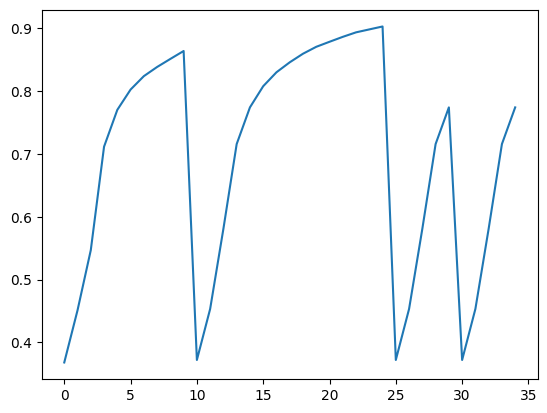

In [15]:
plt.plot(mean_acc)